<Figure size 1980x1080 with 0 Axes>

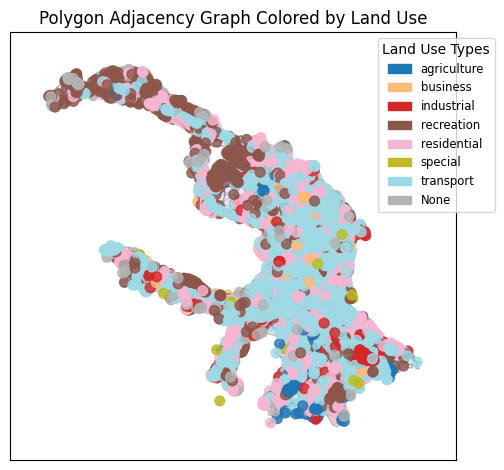

Number of nodes: 16337
Number of edges: 53471
Average degree: 6.55
Number of unique land use types: 7


In [9]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Load your GeoDataFrame
gdf = gpd.read_file('data/data_lu/blocks_best_feature.gpkg')

# Step 1: Calculate centroids for each polygon
gdf['centroid'] = gdf.geometry.centroid

# Step 2: Find adjacent polygons
# Create a spatial index for efficient spatial queries
spatial_index = gdf.sindex

# Function to find adjacent polygons
def find_neighbors(gdf):
    neighbors = {}
    for idx, geom in enumerate(gdf.geometry):
        # Buffer slightly to catch polygons that touch at points
        # or have very small gaps due to numerical precision
        buffered = geom.buffer(0.0001)
        
        # Find potential neighbors using spatial index
        potential_neighbors = list(spatial_index.intersection(buffered.bounds))
        
        # Remove self from potential neighbors
        if idx in potential_neighbors:
            potential_neighbors.remove(idx)
        
        # Check for actual intersection/touching
        neighbors[idx] = [
            neigh_idx for neigh_idx in potential_neighbors
            if geom.touches(gdf.geometry.iloc[neigh_idx]) or 
               geom.intersects(gdf.geometry.iloc[neigh_idx])
        ]
    
    return neighbors

# Get the neighbors dictionary
neighbors_dict = find_neighbors(gdf)

# Step 3: Create a graph
G = nx.Graph()

# Add nodes with positions based on centroids
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.centroid.x, row.centroid.y), 
               geometry=row.geometry,
               land_use=row.land_use)

# Add edges based on adjacency
for node, neighbors in neighbors_dict.items():
    for neighbor in neighbors:
        G.add_edge(node, neighbor)

# Step 4: Prepare for visualization with land_use coloring
plt.figure(figsize=(19.8, 10.8))

# Plot the polygons
ax = gdf.plot(color='lightgrey', edgecolor='grey', alpha=0.5)

# Get node positions
pos = nx.get_node_attributes(G, 'pos')

# Get land_use attributes for all nodes
land_use_values = nx.get_node_attributes(G, 'land_use')

# Create a list of unique land_use values (excluding None)
unique_land_uses = sorted(list(set([lu for lu in land_use_values.values() if lu is not None])))

# Create a color map for land_use values
# Using a colorblind-friendly palette
color_palette = plt.cm.tab20(np.linspace(0, 1, len(unique_land_uses)))
land_use_colors = {lu: color_palette[i] for i, lu in enumerate(unique_land_uses)}
land_use_colors[None] = (0.7, 0.7, 0.7, 1.0)  # Grey for None values

# Map nodes to colors based on land_use
node_colors = [land_use_colors[land_use_values[node]] for node in G.nodes()]

# Draw the graph with colored nodes
nx.draw_networkx_nodes(
    G, 
    pos=pos,
    node_size=50,
    node_color=node_colors,
    alpha=0.8
)

nx.draw_networkx_edges(
    G,
    pos=pos,
    width=0.5,
    edge_color='blue',
    alpha=0.3
)

# Create a legend
legend_patches = [mpatches.Patch(color=land_use_colors[lu], label=lu) 
                 for lu in unique_land_uses]
if None in land_use_colors:
    legend_patches.append(mpatches.Patch(color=land_use_colors[None], label='None'))

plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.1, 1),
           title='Land Use Types', fontsize='small')

plt.title('Polygon Adjacency Graph Colored by Land Use')
plt.tight_layout()
plt.show()

# Print some basic graph statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {np.mean([d for n, d in G.degree()]):.2f}")
print(f"Number of unique land use types: {len(unique_land_uses)}")
